In [5]:
import Parity_Data_Generator
import numpy as np
from pyESN import ESN
import time

N = 3000   # number of datapoints
n = 3       # n-parity
timescale = 50
rng = np.random.RandomState(42)



start_time = time.time()
# produce Data
bits, parity, target = Parity_Data_Generator.generateParityData(N, n, randomstate=rng)

# Divide in training and test data
traintest_cutoff = int(np.ceil(0.7 * len(bits)))
train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
train_parity, test_parity = parity[:traintest_cutoff], parity[traintest_cutoff:]
train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]

print("--- %s seconds ---" % (time.time() - start_time))

In [12]:
def runSomeConfigs(spectral_rad, leak_r, train_b, test_b, train_p, test_p, n_neurons):
#     print("Spectral-radius:",spectral_rad, "leak-rate:", leak_r)
    nParityESN = ESN(n_inputs=1,
                          n_outputs=1,
                          n_reservoir=n_neurons,  # from 200 onwards test error decreases significantly
                          spectral_radius=spectral_rad,  # high spectral rad is better (high fluctuations 0->1->0)
                          leak_rate= leak_r,   # adjust leak_rate
                          sparsity=0.95,
                          noise=0.01,
                          input_shift=0,
                          input_scaling=3,  # 3 seems to be fine. Maybe use lower
                          teacher_forcing=False,
                          teacher_scaling=1.12,
                          teacher_shift=-0.7,
#                           out_activation=np.tanh,
#                           inverse_out_activation=np.arctanh,
                          random_state=rng,
                          silent=False)
    # print(np.shape(bits),np.shape(parity),np.shape(target))
    nParityESN.fit(train_b, train_p)
    pred_test = nParityESN.predict(test_b)

    #### not rounding
    predictedParity = pred_test # not rounding
    #### Rounding
#     better_pred_test = []           # Maybe don't round and return "true" results from pred_test
#     for x in pred_test:
#         better_pred_test.append(0 if x < 0.5 else 1)
#     predictedParity = np.array(better_pred_test).reshape(-1,1)
#     print(test_parity[40030:40100].reshape(-1))
#     print(predictedParity[40030:40100].reshape(-1))
    
    print("Testing error")
    test_error = np.sqrt(np.mean((predictedParity - test_p) ** 2))
    print(test_error)
    return test_error



In [13]:
def produceTrainingData(i):
    bits, parity, target = Parity_Data_Generator.generateParityData(N, n, timescale=timescale, 
                                                                    randomstate=np.random.RandomState(i))

    # Divide in training and test data
    traintest_cutoff = int(np.ceil(0.7 * len(bits)))
    train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
    train_parity, test_parity = parity[:traintest_cutoff], parity[traintest_cutoff:]
#     train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]
    return train_bits, test_bits, train_parity, test_parity


In [15]:
trials = 1
n_neurons = 250

l_rate = np.linspace(0.1, 1, num=10)
# l_rate =[0.2]
# l_rate = [0.1,0.2,0.3]

# sp_rad = np.linspace(0.9, 1.0, num=5)
sp_rad = np.linspace(0.1, 1, num=10)
# sp_rad = [0.8]

run_time = time.time()
iterations, iterationcount = trials*len(sp_rad)*len(l_rate), 0
errors = []
all_errors = [{} for _ in range(trials)] # empty dict
for i in range(trials):
    errors = []
    # produce training and testing data
    train_bits, test_bits, train_parity, test_parity = produceTrainingData(i)
    for l in l_rate:
        for s in sp_rad:
            print("Neurons:", n_neurons,"Leak-rate:",l,"Spectral-radius:",s)
            errors.append(runSomeConfigs(s,l, train_bits, test_bits, train_parity, test_parity, n_neurons))
            iterationcount = iterationcount + 1
            print("--- Progress: {:.2f}% --- {:.2f} minutes ---".format(iterationcount/iterations*100, ((time.time() - run_time)/60) ))
    ## Save leak-rate,spectral-radius and error in dictionary
    all_errors[i] = errors
            
print("Total time for Testbench:")
print("--- {:.2f} seconds ---".format(time.time() - run_time))
print("--- {:.2f} minutes ---".format(((time.time() - run_time)/60)))

Neurons: 250 Leak-rate: 0.1 Spectral-radius: 0.1
harvesting states...
fitting...
training error:
0.458733964204
Testing error
0.468412949649
--- Progress: 1.00% --- 0.17 minutes ---
Neurons: 250 Leak-rate: 0.1 Spectral-radius: 0.2
harvesting states...
fitting...
training error:
0.441897051105
Testing error
0.45421014779
--- Progress: 2.00% --- 0.34 minutes ---
Neurons: 250 Leak-rate: 0.1 Spectral-radius: 0.3
harvesting states...
fitting...
training error:
0.410216776683
Testing error
0.509268060475
--- Progress: 3.00% --- 0.51 minutes ---
Neurons: 250 Leak-rate: 0.1 Spectral-radius: 0.4
harvesting states...
fitting...
training error:
0.446577354873
Testing error
0.507344037232
--- Progress: 4.00% --- 0.69 minutes ---
Neurons: 250 Leak-rate: 0.1 Spectral-radius: 0.5
harvesting states...
fitting...
training error:
0.409387697491
Testing error
0.428371971449
--- Progress: 5.00% --- 0.86 minutes ---
Neurons: 250 Leak-rate: 0.1 Spectral-radius: 0.6
harvesting states...
fitting...
training e

In [16]:
import pickle
#### Save Data
with open('datasaveAverageSmallerSlowESN.p', 'wb') as outputFile:
    pickle.dump(all_errors, outputFile)
#     pickle.dump(num_neurons, outputFile)
    pickle.dump(trials, outputFile)
    pickle.dump(l_rate, outputFile)
    pickle.dump(sp_rad, outputFile)
#### Load Data
# with open('datasaveAverageSmallerSlowESN.p', 'rb') as inputFile:
#     all_errors = pickle.load(inputFile)
# #     num_neurons = pickle.load(inputFile)
#     trials = pickle.load(inputFile)
#     l_rate = pickle.load(inputFile)
#     sp_rad = pickle.load(inputFile)

In [17]:
### Average errors
errorLists = np.zeros(100)
for i in range(len(all_errors)):
    e = all_errors[i]
    errorLists = np.add(errorLists, np.array(e))

errorLists = np.divide(errorLists, trials)

In [20]:
import plotly.plotly as py
import plotly.graph_objs as go

# c= ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(all_errors))]
# c= ["blue", "orange", "green", "cyan", "yellow", "magenta", "red", "black"]

x = np.repeat(l_rate,len(l_rate))
y = np.tile(sp_rad, len(sp_rad))
z = errorLists
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    name=("Averaged over", trials ,"Trials"),
    mode='markers',
    marker=dict(
        size=7,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     ),
#     go.zaxis=dict(
#         range=[0, 0.8]
#     ),
    scene=go.Scene(
        xaxis=go.XAxis(title='x = Leak-Rate'),
        yaxis=go.YAxis(title='y = Spectral Radius'),
        zaxis=go.ZAxis(title='z = Error')
        )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='SlowESN average Error')

In [47]:
data = [
     go.Contour(
        z=errorLists.reshape(10,10).T,
        x=l_rate,
        y=sp_rad,
        colorscale='Jet',
    )]
py.iplot(data)

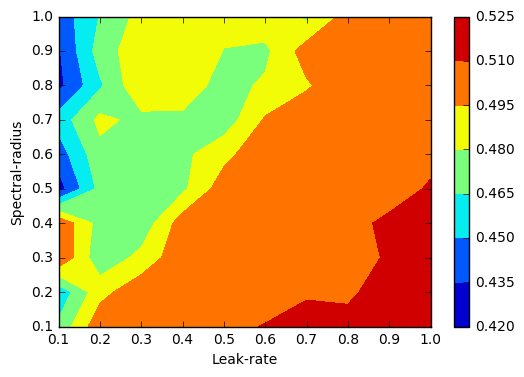

In [44]:
from matplotlib import pyplot
%matplotlib inline
pyplot.contourf(np.repeat(l_rate,len(l_rate)).reshape(10,10),
                np.tile(sp_rad, len(sp_rad)).reshape(10,10),errorLists.reshape(10,10))
pyplot.xlabel("Leak-rate")
pyplot.ylabel("Spectral-radius")
pyplot.colorbar()

In [48]:
#### Get Parameters from a good performing slowESN

nParityESN = ESN(n_inputs=1,
                          n_outputs=1,
                          n_reservoir=250,  # from 200 onwards test error decreases significantly
                          spectral_radius=0.9,  # high spectral rad is better (high fluctuations 0->1->0)
                          leak_rate= 0.1,   # adjust leak_rate
                          sparsity=0.95,     # 0.95
                          noise=0.01,      # 0.001
                          input_shift=-0.5,    # 0
                          input_scaling=3,  # 3 seems to be fine. Maybe use lower
                          teacher_forcing=False,
                          teacher_scaling=1.12,
                          teacher_shift=-0.7,
#                           out_activation=np.tanh,
#                           inverse_out_activation=np.arctanh,
                          random_state=rng,
                          silent=False)
nParityESN.fit(train_bits, train_parity)

harvesting states...
fitting...
training error:
0.396602962906


array([[ 0.5959933 ],
       [ 0.6777903 ],
       [ 0.53564243],
       ..., 
       [ 0.19607419],
       [ 0.27359514],
       [ 0.30469634]])

In [49]:
##### Create Training Data for fastESN with output from slowESN
start_time = time.time()

new_rng = np.random.RandomState(1337)
new_N, new_n = 1500, 3
# new_bits, new_parity, new_target = Parity_Data_Generator.generateParityData(new_N, new_n, 
#                                                                             timescale=timescale,randomstate=new_rng)

# # Divide in training and test data
# traintest_cutoff = int(np.ceil(0.7 * len(bits)))
# new_train_bits, new_test_bits = new_bits[:traintest_cutoff], new_bits[traintest_cutoff:]
# # new_train_parity, new_test_parity = new_parity[:traintest_cutoff], new_parity[traintest_cutoff:]
# new_train_targets, new_test_targets = new_target[:traintest_cutoff], new_target[traintest_cutoff:]

# train_predicted_parity = nParityESN.predict(new_train_bits)
# test_predicted_parity = nParityESN.predict(new_test_bits)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0 seconds ---


In [50]:
#### FastESN ####
def runSomeFastConfigs(spectral_rad, leak_r, train_parity, test_parity, 
                       train_targets, test_targets, num_neurons=100):
    outputESN = ESN(n_inputs=1,
                              n_outputs=1,
                              n_reservoir=num_neurons,  
                              spectral_radius=spectral_rad,  # high spectral rad is better (high fluctuations 0->1->0)
                              leak_rate= leak_r,   # adjust leak_rate
                              sparsity=0.95,
                              noise=0.01,
                              input_shift=0,
                              input_scaling=3,  # 3 seems to be fine. Maybe use lower
                              teacher_forcing=False,
                              teacher_scaling=1.12,
                              teacher_shift=-0.4,
#                               out_activation=np.tanh,
#                               inverse_out_activation=np.arctanh,
                              random_state=new_rng,
                              silent=False)
        # print(np.shape(bits),np.shape(parity),np.shape(target))
    outputESN.fit(train_parity, train_targets)
    pred_test = outputESN.predict(test_parity)
        
    print("Testing error")
    test_error = np.sqrt(np.mean((pred_test - test_targets) ** 2))
    print(test_error)
    return test_error

def produceFastTrainingData(randomState):
    bits, parity, target = Parity_Data_Generator.generateParityData(N, n, timescale=timescale, 
                                                                    randomstate=np.random.RandomState(randomState))

    # Divide in training and test data
    traintest_cutoff = int(np.ceil(0.7 * len(bits)))
    train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
    train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]
    
    train_predicted_parity = nParityESN.predict(train_bits)
    test_predicted_parity = nParityESN.predict(test_bits)
    
    return train_predicted_parity, test_predicted_parity, train_targets, test_targets

In [51]:
new_trials = 1
n_neurons = 100
# num_neurons_fast = [100]
# l_rate_fast = np.linspace(0.4, 1, num=7)
l_rate_fast = np.linspace(0.1, 1, num=10)
# l_rate_fast = [0.6]
# sp_rad_fast = np.linspace(0.8, 1, num=3)
sp_rad_fast = np.linspace(0.1, 1, num=10)
# sp_rad_fast = [0.95]

run_time = time.time()
iterations, iterationcount = new_trials*len(sp_rad_fast)*len(l_rate_fast), 0
errors = []
all_errors_fast = [{} for _ in range(new_trials)]
for i in range(new_trials):
    errors = []
    
    new_train_parity, new_test_parity, new_train_targets, new_test_targets = produceFastTrainingData(i)
    
    for l in l_rate_fast:
        for s in sp_rad_fast:
            print("Neurons:", n_neurons, "Leak-rate:", l, "Spectral-radius:", s)
            errors.append(runSomeFastConfigs(s,l,new_train_parity, new_test_parity, new_train_targets, new_test_targets,n_neurons))
            iterationcount = iterationcount + 1
            print("--- Progress: {:.2f}% --- {:.2f} minutes ---".format(iterationcount/iterations*100, ((time.time() - run_time)/60) ))
    ## Save leak-rate,spectral-radius and error in dictionary
    all_errors_fast[i] = errors
            
print("Total time for Testbench:")
print("--- {:.2f} seconds ---".format(time.time() - run_time))
print("--- {:.2f} minutes ---".format(((time.time() - run_time)/60)))

Neurons: 100 Leak-rate: 0.1 Spectral-radius: 0.1
harvesting states...
fitting...
training error:
0.375442390625
Testing error
0.363465218118
--- Progress: 1.00% --- 0.23 minutes ---
Neurons: 100 Leak-rate: 0.1 Spectral-radius: 0.2
harvesting states...
fitting...
training error:
0.374016895054
Testing error
0.365058401284
--- Progress: 2.00% --- 0.32 minutes ---
Neurons: 100 Leak-rate: 0.1 Spectral-radius: 0.3
harvesting states...
fitting...
training error:
0.365346876397
Testing error
0.353417489245
--- Progress: 3.00% --- 0.41 minutes ---
Neurons: 100 Leak-rate: 0.1 Spectral-radius: 0.4
harvesting states...
fitting...
training error:
0.371412443252
Testing error
0.362571594972
--- Progress: 4.00% --- 0.50 minutes ---
Neurons: 100 Leak-rate: 0.1 Spectral-radius: 0.5
harvesting states...
fitting...
training error:
0.37623012372
Testing error
0.369944337529
--- Progress: 5.00% --- 0.59 minutes ---
Neurons: 100 Leak-rate: 0.1 Spectral-radius: 0.6
harvesting states...
fitting...
training e

In [61]:
import pickle
#### Save Data
with open('datasaveFastAverage.p', 'wb') as outputFile:
    pickle.dump(all_errors_fast, outputFile)
#     pickle.dump(num_neurons_fast, outputFile)
    pickle.dump(new_trials, outputFile)
    pickle.dump(l_rate_fast, outputFile)
    pickle.dump(sp_rad_fast, outputFile)
#### Load Data
# with open('datasaveFastAverage.p', 'rb') as inputFile:
#     all_errors_fast = pickle.load(inputFile)
# #      num_neurons_fast = pickle.load(inputFile)
#     new_trials = pickle.load(inputFile)
#     l_rate_fast = pickle.load(inputFile)
#     sp_rad_fast = pickle.load(inputFile)

In [62]:
### Average errors
fast_errorLists = np.zeros(100)
for i in range(len(all_errors_fast)):
    e = all_errors_fast[i]
    fast_errorLists = np.add(fast_errorLists, np.array(e))

fast_errorLists = np.divide(fast_errorLists, new_trials)

In [63]:
import plotly.plotly as py
import plotly.graph_objs as go

# c= ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(all_errors_fast))]
c= ["blue", "orange", "green", "cyan", "yellow", "magenta", "red", "black"]
data = []


x = np.repeat(l_rate_fast,len(l_rate_fast))
y = np.tile(sp_rad_fast,len(sp_rad_fast))
z = fast_errorLists

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    name=("Fast network averaged over",trials,"Trials"),
    mode='markers',
    marker=dict(
        size=7,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)


data = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     ),
#     go.zaxis=dict(
#         range=[0, 0.8]
#     ),
    scene=go.Scene(
        xaxis=go.XAxis(title='x = Leak-Rate'),
        yaxis=go.YAxis(title='y = Spectral Radius'),
        zaxis=go.ZAxis(title='z = Error')
        )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Fast Network Averaged')

In [64]:
data = [
     go.Contour(
        z=fast_errorLists.reshape(10,10).T,
        x=l_rate_fast,
        y=sp_rad_fast,
        colorscale='Jet',
    )]
py.iplot(data)

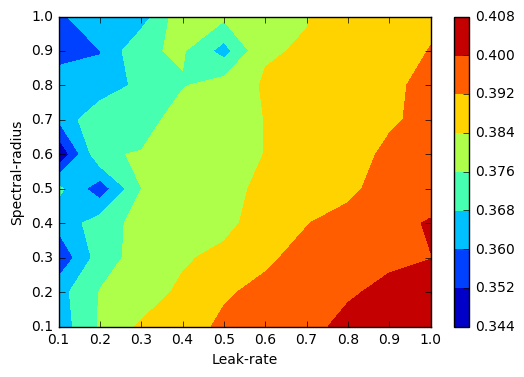

In [65]:
from matplotlib import pyplot
%matplotlib inline
pyplot.contourf(np.repeat(l_rate_fast,len(l_rate_fast)).reshape(10,10),
                np.tile(sp_rad_fast, len(sp_rad_fast)).reshape(10,10),fast_errorLists.reshape(10,10))
pyplot.xlabel("Leak-rate")
pyplot.ylabel("Spectral-radius")
pyplot.colorbar()